In [150]:
import speech_recognition as sr
import pyaudio #python bindings for PortAudio the cross_platform audio i/o  library
import wave
import matplotlib.pyplot as plt
import librosa.display
import librosa
import sklearn
from IPython.display import Audio, display

c=0

In [151]:
def choose_microphone():
    print("Available Microphones:")
    microphones = sr.Microphone.list_microphone_names()
    for i, mic in enumerate(microphones):
        print(f"{i}: {mic}")
    while True:
        choice = input("Enter the index or name of the microphone you want to use to record audio: ")
        if choice.isdigit():
            choice = int(choice)
            if 0 <= choice < len(microphones):
                return choice
        elif choice in microphones:
            return choice
        print("Invalid choice. Please enter a valid index or microphone name.")
#mic = choose_microphone()
chosen_microphone = choose_microphone()

#print(mic)

Available Microphones:
0: Built-in Microphone
1: Built-in Output
2: USB Audio Device
3: USB Audio Device
4: Soundflower (2ch)
5: Soundflower (64ch)
6: Screenflick Loopback
7: iShowU Audio Capture
8: Périphérique agrégé
9: Périphérique à sortie multiple


In [152]:
def play_audio(audio):
    audio_data = audio.get_wav_data()
    with wave.open("temp_audio.wav", "wb") as f:
        f.setnchannels(1)
        f.setsampwidth(pyaudio.PyAudio().get_sample_size(pyaudio.paInt16))
        f.setframerate(16000)
        f.writeframes(audio_data)
        
    # Open the temporary WAV file and play it
    p = pyaudio.PyAudio()
    wf = wave.open("temp_audio.wav", "rb")# read byte mode
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(1024)
    while data:
        stream.write(data)
        data = wf.readframes(1024)
    stream.stop_stream()
    stream.close()
    p.terminate()

In [153]:
def save_audio(audio,c):   
# write wave file
    sample_rate = 48000.0 #hertz
    frames = audio.get_wav_data()
    obj= wave.open(f"audio_wave_rec/output_rec{c}.wav",'w')# write  mode
    obj.setnchannels(1)#mono
    obj.setsampwidth(2)
    obj.setframerate(sample_rate)
    obj.writeframes(frames)
    obj.close()

In [154]:
def record_text(chosen_microphone,c):
    recognizer = sr.Recognizer()
    #chosen_microphone = choose_microphone()
    with sr.Microphone(device_index=chosen_microphone) as source:
        print("Listening...")
        recognizer.adjust_for_ambient_noise(source)  # Adjust for noise
        audio = recognizer.listen(source)
        # Play back the captured audio
        #play_audio(audio)
        
        # Save the captured audio to a WAV file
        save_audio(audio,c)

    try:
        #text = recognizer.recognize_google(audio)  # Use Google's speech recognition
         # Specify language parameter for Arabic ('ar')
        text = recognizer.recognize_google(audio, language='ar')
        print(text)
        return text
    except sr.UnknownValueError:
        print("Could not understand audio")
        return ""
    except sr.RequestError as e:
        print("Could not request results; {0}".format(e))
        return ""

#text = record_text()

In [155]:
def output_text(text):
    with open("audio_to_text_output.txt", "a") as f:
        f.write(text + "\n")
#output_text(text)

In [156]:
while c<=5:#while True
    text = record_text(chosen_microphone,c)
    output_text(text)
    print(f"Recorded text {c}:", text)
    c += 1


Listening...
مرحبا
Recorded text 0: مرحبا
Listening...
كيف حال اكس بيتشي
Recorded text 1: كيف حال اكس بيتشي
Listening...
Could not understand audio
Recorded text 2: 
Listening...
السلام
Recorded text 3: السلام
Listening...


KeyboardInterrupt: 

In [129]:
path= f"audio_wave_rec/output_rec{0}.wav"
display(Audio(path))

In [130]:

#open wave file
obj = wave.open(path,'r')# read mode

print("number of channels", obj.getnchannels())
print("sample width", obj.getsampwidth())
print("frame rate", obj.getframerate())
print("number of frames", obj.getnframes())
print("parameters", obj.getparams())
frames = obj.readframes(obj.getnframes())
obj.close()



number of channels 1
sample width 2
frame rate 48000
number of frames 72726
parameters _wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=72726, comptype='NONE', compname='not compressed')


In [131]:
data, sr = librosa.load(path, sr=48000) #sample rate
print(data.shape, sr)

(72726,) 48000


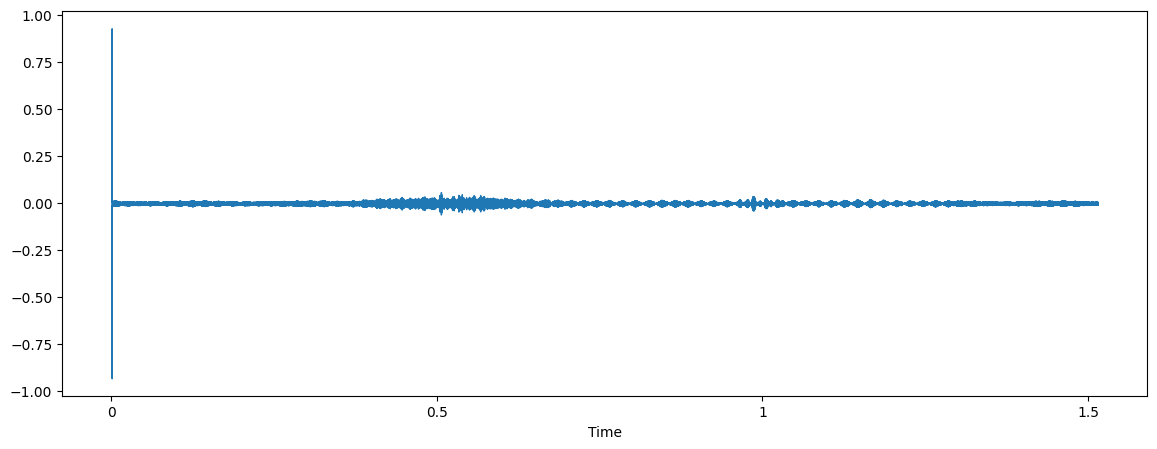

In [132]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sr)

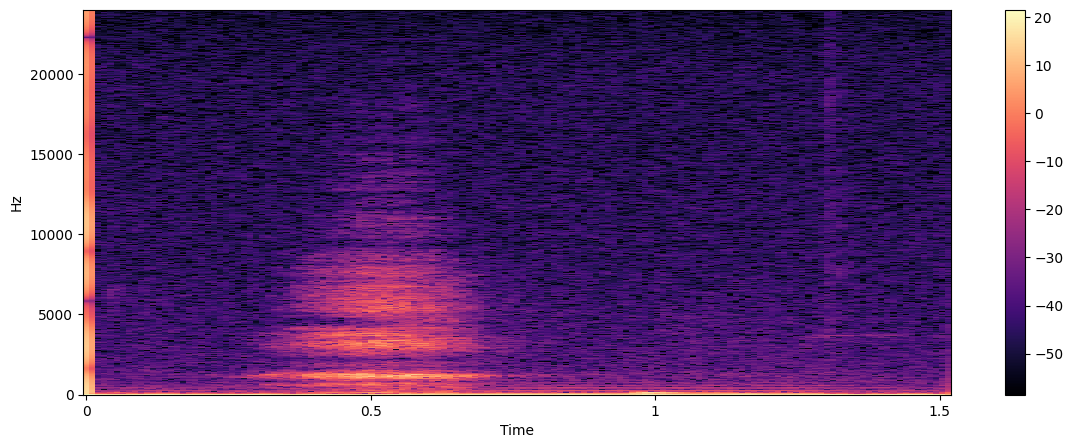

In [133]:
# spectrogram

X = librosa.stft(data) #short-time Fourier transform (STFT)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

(143,)


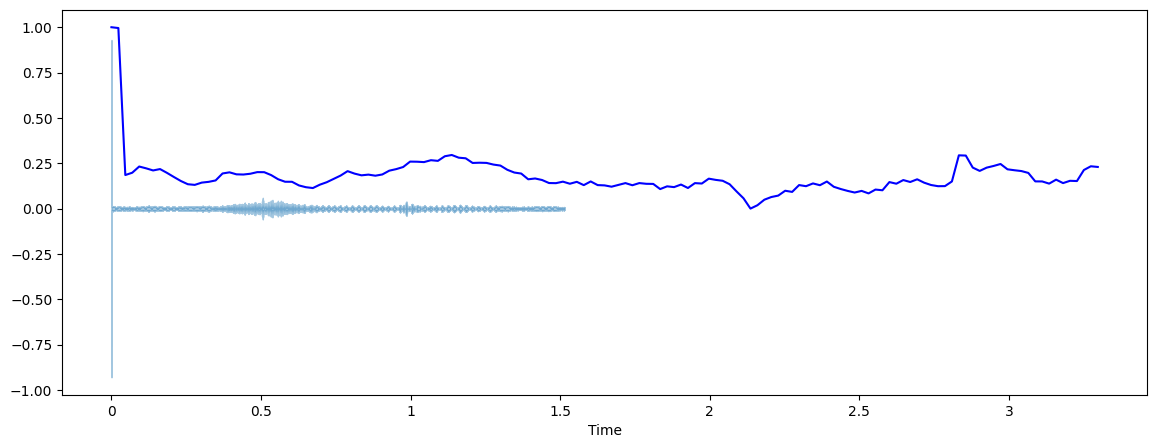

In [134]:
#Features Analysis, Spectral Centroid
import sklearn.preprocessing


spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sr)[0]
print(spectral_centroids.shape)

#computing the time variable for visualization
plt.figure(figsize=(14,5))
frames = range(len(spectral_centroids))
t= librosa.frames_to_time(frames)

#normalizing the spectral centroids for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=0)
#plotting the spectral centroids along the waveform
librosa.display.waveshow(data, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')